In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit, GridSearchCV

import pylab as plot
pd.options.display.float_format = '{:,.6g}'.format
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 100

# Interpretability: Peeking inside the Black Box using ICE and PD plots


**Highlights**
1. It is possible to interpret the behavior of complex machine learning models using PD and ICE plots.
2. PD plots can show if the relationship between target and feature is linear, monotonic, or complex.
3. These plots can be quite effective at sharing insights to colleagues or non-technical people.

# 1. Background


In machine learning, there are two ways of extracting inferences from data. The first technique is data modeling, which assumes that the data is created by a certain stochastic data model. Common models include linear and logistic regression. These models forecast future input variable responses and give information on how the response variables and input variables are related. (In other words, they can be interpreted.) Second, algorithmic modeling models are based on the assumption that the underlying data process is unknown. The objective is to create an algorithm, such as random forests or neural networks, that predicts the response variables based on the input variables. These algorithms predict future input variable responses but do not give information on how the response variables and input variables are connected. To put it another way, these algorithms produce black box models since they do not give a concrete explanation for their predictions. (In other words, they cannot be interpreted.)

Because they can model complex data relationships, algorithms such as gradient boosting, random forest, and neural nets outperform classical models in terms of prediction accuracy for complex prediction tasks. These machine learning algorithms just make predictions and do not give any explanations. As a consequence, they simply address the "what" of a query but not the "why," and so do not allow for genuine scientific results[[1](https://compstat-lmu.github.io/iml_methods_limitations/introduction.html)]. The capacity to interpret scientific findings is essential, especially in disciplines such as biological and social sciences, which aim to uncover causal connections between input and response variables.

This notebook introduces current post-hoc and model agnostic approaches such as Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE). These methods can be used to explain the behavior and predictions of trained machine learning models. However, their reliability and compactness deteriorate when models use a high number of features, have strong feature interactions and complex feature main effects among others.


## 1.1. Model-Agnostic Methods

### 1. Partial Dependence Plots (PDP)
The Partial Dependence Plot (PDP) is a rather intuitive and easy-to-understand visualization of the features' impact on the predicted outcome. A PDP can show whether the relationship between the target and a feature is linear, monotonic or more complex.[[2](https://christophm.github.io/interpretable-ml-book/pdp.html)]

PDP reduces the prediction function to a function that depends on only one or two features. It reduce the function by averaging the effects of the other features. However, this holds only true as long as the feature in question is not correlated with any other features of the model.

The partial dependence function for regression is defined as:

<div align="center">
$\hat{f}_{x_S}(x_S)=\frac{1}{n}\sum_{i=1}^n\hat{f}(x_S,x^{(i)}_{C})$
</div>
    
    
The partial function tells us for given value(s) of features S what the average marginal effect on the prediction is. In this formula, $x^{(i)}_{C}$  are actual feature values from the dataset for the features in which we are not interested, and $n$ is the number of instances in the dataset. 

    
### 2. Individual Conditional Expectation (ICE)


Individual Conditional Expectation (ICE) plots show one line per instance, indicating how the prediction of the instance varies as a feature changes.
The partial dependency plot for the average influence of a feature is a global method since it focuses on an overall average rather than particular occurrences. Individual conditional expectation (ICE) plots are the equivalent to PDPs for individual data instances. A PDP is the average of the lines of an ICE plot. [[3](https://christophm.github.io/interpretable-ml-book/ice.html)].


**Notes**: 
1. For classification, the target response may be the probability of a class (the positive class for binary classification), or the decision function.
2. The PD and ICE plots are calculated only after the model has been fit. 



For the PD and ICE demo, we will use the `plot_partial_dependence` package from sklearn. The documentation is found [[here](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html#sklearn.inspection.plot_partial_dependence)].

Again, we will need to have a trained ML model for the implementaion. For this study, we will run 7 ML models on our regression problem. Afterwards, we apply the PD and ICE on the best model.

# 2. Data

Our dataset contains 1,338 medical insurance records. The individual medical costs billed by health insurance are the target variable charges, and the rest of columns contain personal information such as age, gender, bmi, number of children, region, and whether the patient smokes. The objective is to train a ML regression model that generates the target column charges more accurately. 


The data is obtained from Kaggle. The link of the data is [here](https://www.kaggle.com/mirichoi0218/insurance).

**Features** 
- `age`: (int) age of primary beneficiary
- `sex`: (str) insurance contractor gender, female, male
- `bmi`: (float) Body mass index (kg / m ^ 2) 
- `children`: (int) Number of children covered by health insurance / Number of dependents
- `smoker`: (bool) 1 if smoker, else 0
- `region`: (str) the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

**Target**
- `charges`: (float) Individual medical costs billed by health insurance

# 2.1 Data Cleaning and Processing

### 2.1.1 Get the data

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

age     sex    bmi  children smoker     region  charges
0   19  female   27.9         0    yes  southwest 16,884.9
1   18    male  33.77         1     no  southeast 1,725.55
2   28    male     33         3     no  southeast 4,449.46
3   33    male 22.705         0     no  northwest 21,984.5
4   32    male  28.88         0     no  northwest 3,866.86

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# rename children column to num_children
df.rename(columns={'children': 'num_children'}, inplace=True)

### 2.1.2 Checking missing values

In [5]:
# checking if there are missing values
df.isna().sum()

age             0
sex             0
bmi             0
num_children    0
smoker          0
region          0
charges         0
dtype: int64

In [6]:
# checking the data types of our features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1338 non-null   int64  
 1   sex           1338 non-null   object 
 2   bmi           1338 non-null   float64
 3   num_children  1338 non-null   int64  
 4   smoker        1338 non-null   object 
 5   region        1338 non-null   object 
 6   charges       1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


### 2.1.3 Eliminating samples or features with missing values

No feature elimination is needed since there are no missing values.

### 2.1.4 Imputation for missing values

No data imputation is needed since there are no missing values.

# 3. Basic EDA

For this study, we will explore our features. We will do univariate and bivariate analyses for each predictors and make inferences from it.

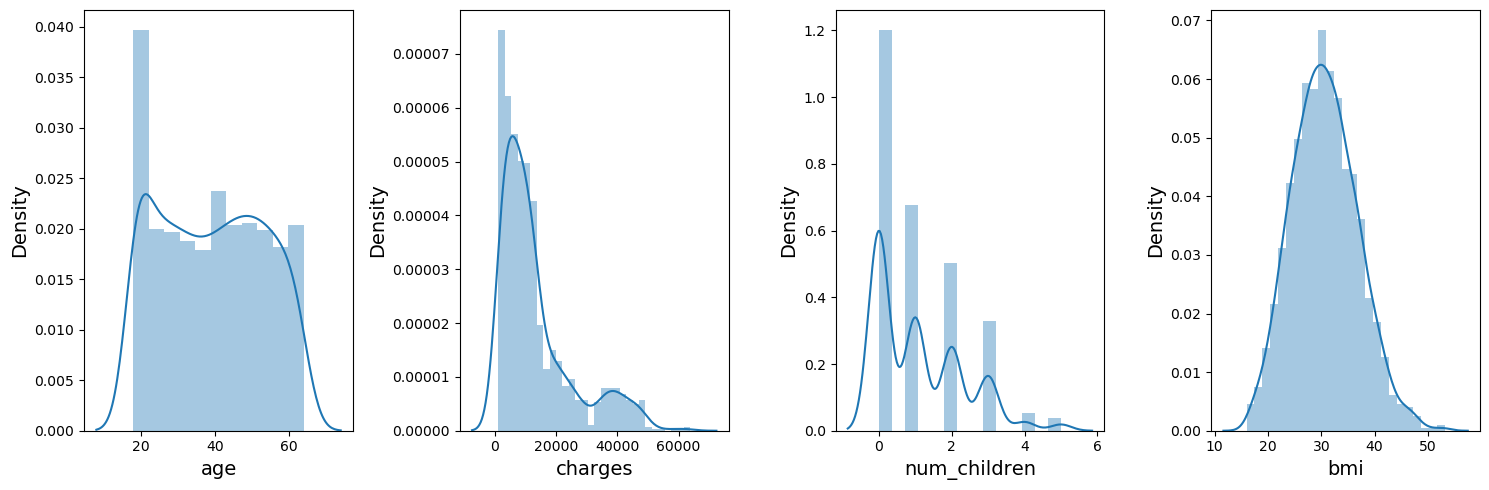

In [7]:
# Univariate analysis
# checking the distribution of numerical columns
cols = ['age', 'charges', 'num_children', 'bmi']
fig, axes = plt.subplots(1,4, figsize=(15,5))
for name, ax in zip(cols, axes.flatten()):
    sns.distplot(x=df[name], ax=ax)
    ax.set_xlabel(name, fontsize=14)
    ax.set_ylabel('Density', fontsize=14)
plt.tight_layout()

The distribution for `charges` is right skewed. We also have imbalance samples for `num_children` greater than 3.

In [8]:
# counts for males and females
df.sex.value_counts()

male      676
female    662
Name: sex, dtype: int64

In [9]:
# Checking the number of females and males who are smokers and non-smokers
smoker_sex = pd.DataFrame(df.groupby('smoker')['sex'].value_counts(
                                                            normalize=True))
print("Rate of smokers for Males and Females")
smoker_sex.rename(columns={'sex': 'counts'})

Rate of smokers for Males and Females


counts
smoker sex            
no     female 0.514098
       male   0.485902
yes    male   0.580292
       female 0.419708

For the smoker population, 58% are males and 42% are females. For the non-smoker population, there is an insignificant difference for both genders.

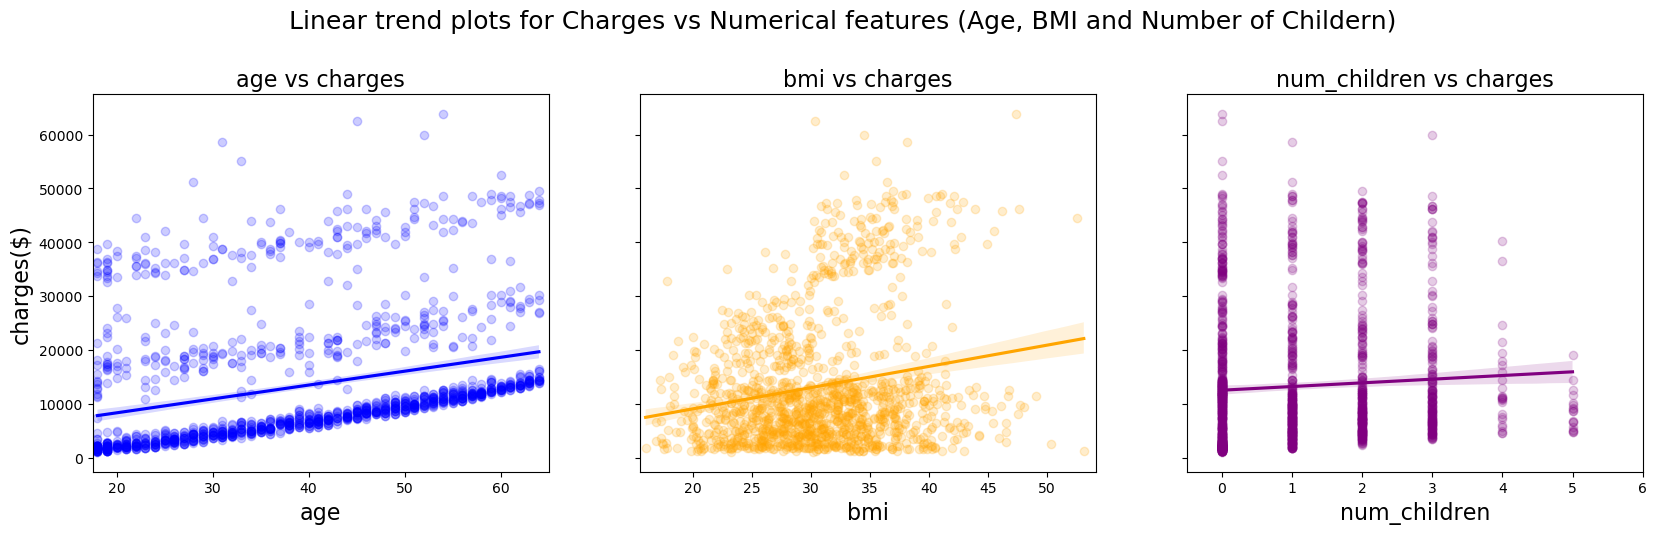

In [10]:
#Bivariate analysis.
#plotting the relationship between insurance charges and the quantitative
#variables: age, bmi, num_children

#create three sets of axes using subplots
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(20,5))

#create a custom plot for each set of axes
for item, i, color in list(zip(['age', 'bmi', 'num_children'], list(range(3)),
                               ['blue', 'orange', 'purple'])):
    sns.regplot(ax=axes[i], data=df, x=df[item], y=df['charges'], 
                scatter_kws={'alpha':0.2}, color=color)
    axes[i].set_title(item + ' vs charges', fontsize=16)
    axes[i].set_xlabel(item, fontsize=16)
    axes[i].set_xlim(df[item].min() - .5, df[item].max() + 1)
    

#make it so the 'charges' y-axis label is only on the left-most set of axes
for ax in axes.flat:
    ax.label_outer()
    
axes[0].set_ylabel('charges($)', fontsize=16)
plt.suptitle('Linear trend plots for Charges vs Numerical features '
             '(Age, BMI and Number of Childern)', fontsize=18, y=1.05)

plt.show()

Age and charges seems to have a linear relationship. The older a person gets, the higher hospital charges will be. Similar relationship can be inferred for BMI and charges. For number of children and charges, the relationship is unclear because of the imbalanced samples. We have a relatively small number of patients with 4-5 children.

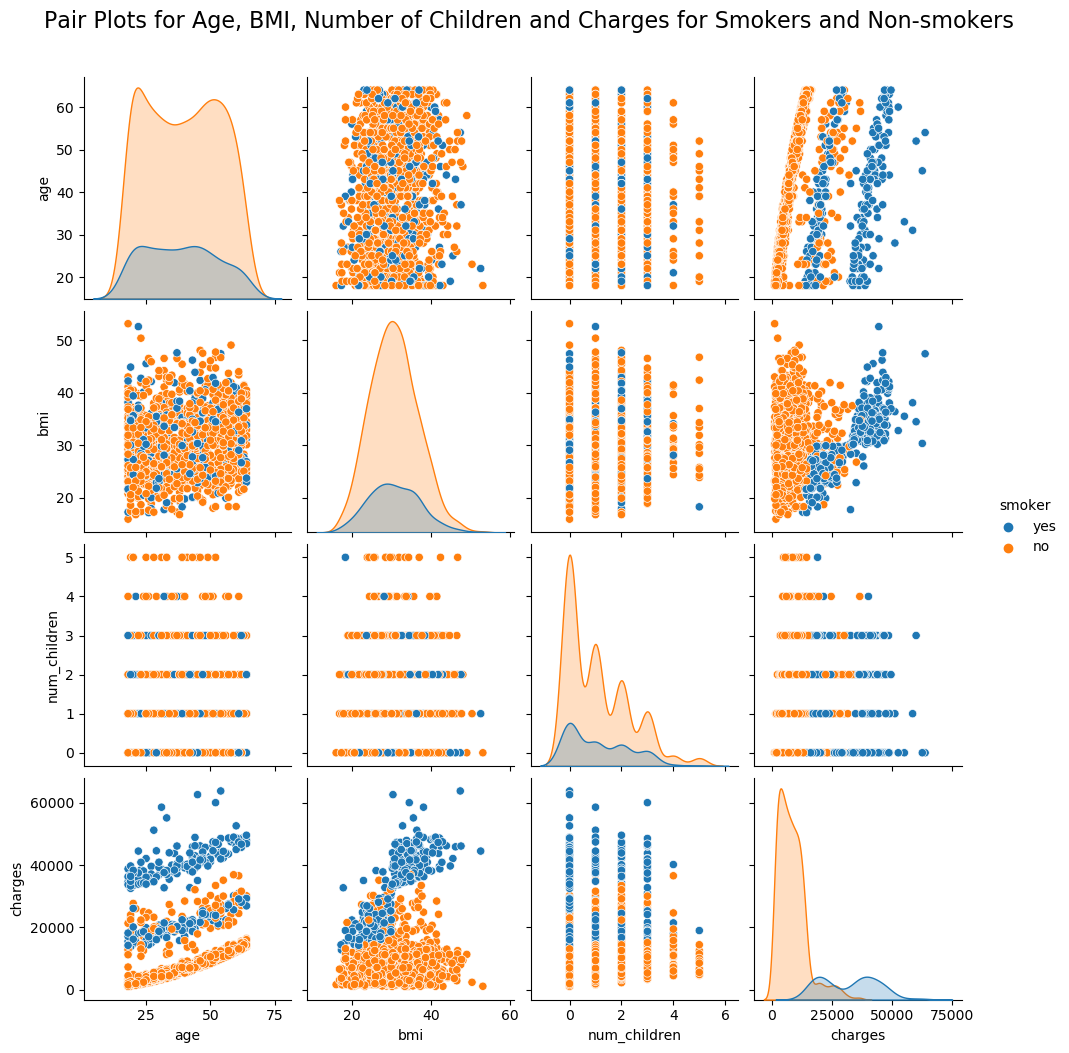

In [11]:
# Compare smoker vs non-smoker
sns.pairplot(df, vars=['age','bmi', 'num_children', 'charges'], hue='smoker')
plt.suptitle('Pair Plots for Age, BMI, Number of Children and Charges for'
             ' Smokers and Non-smokers', size=16, y=1.05);

There is definitely a correlation between smoking and medical charges (with smoking leading to higher charges). Moreover, there seems to have a clear separation between age and charges for smokers and non-smokers. Same observation can be said for age and bmi for smoker and non-smoker patients. Smokers with high BMI have higher charges. Smokers regardless of age have also higher charges compared to non-smokers.

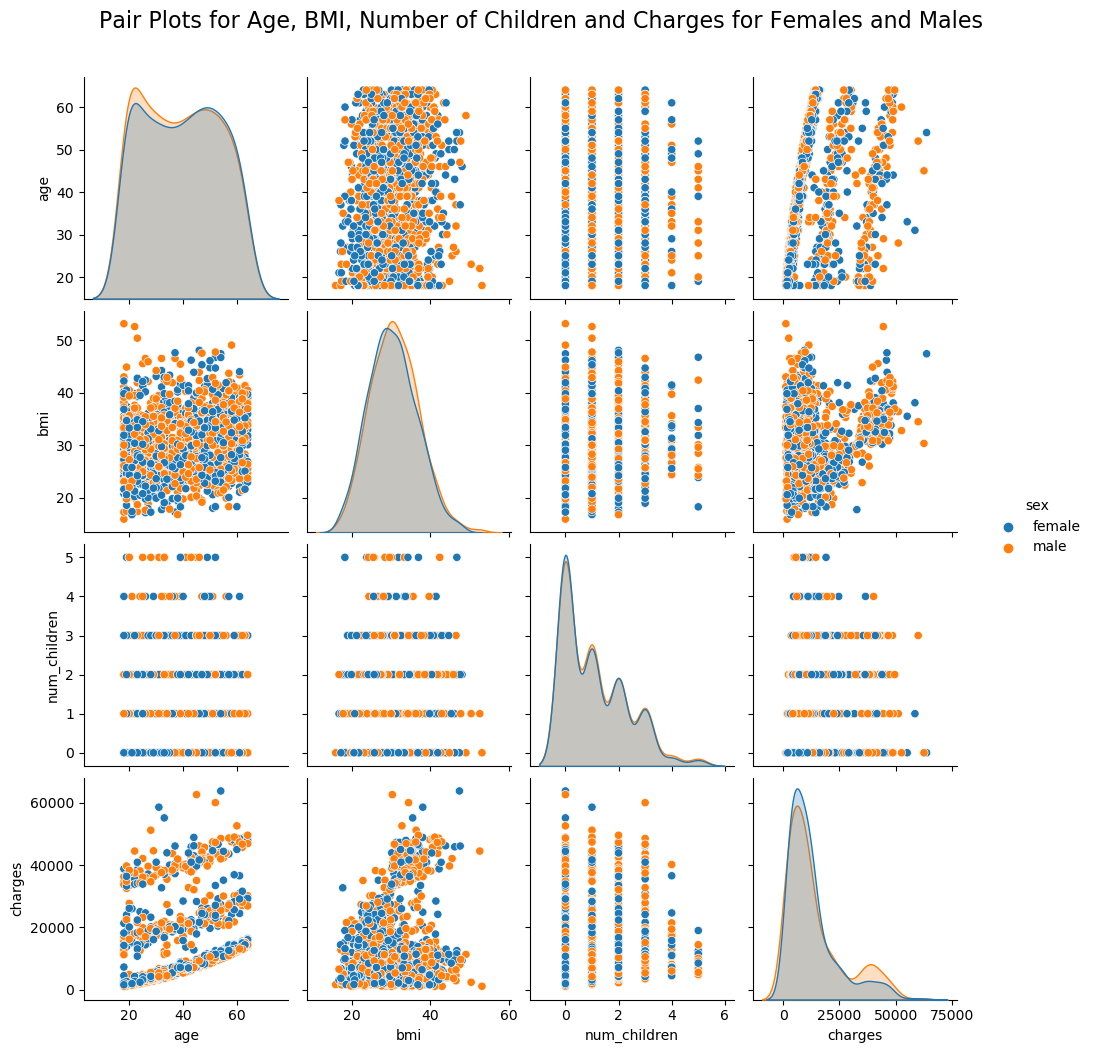

In [12]:
# Add in some of the categorical data as hues, starting with sex
sns.pairplot(df, vars=['age','bmi', 'num_children', 'charges'], hue='sex')
plt.suptitle('Pair Plots for Age, BMI, Number of Children and Charges for'
             ' Females and Males', size=16, y=1.05);

However, no clear correlation is seen between BMI and charges for males and females. Similarly, no clear relationship can be seen between age and charges for both genders (samples are scattered for males and females). It seems that gender does not affect charges.

In [13]:
print("Basic Statistics of the patients' medical charges per Region")
df.groupby('region')['charges'].describe()

Basic Statistics of the patients' medical charges per Region


count     mean      std      min      25%      50%      75%  \
region                                                                   
northeast    324 13,406.4 11,255.8  1,694.8 5,194.32 10,057.7 16,687.4   
northwest    325 12,417.6 11,072.3 1,621.34 4,719.74  8,965.8 14,711.7   
southeast    364 14,735.4 13,971.1 1,121.87 4,440.89 9,294.13 19,526.3   
southwest    325 12,346.9 11,557.2 1,241.57 4,751.07 8,798.59 13,462.5   

               max  
region              
northeast 58,571.1  
northwest 60,021.4  
southeast 63,770.4  
southwest 52,590.8

It seems that patients residing in the Southeast have higher charges on average.

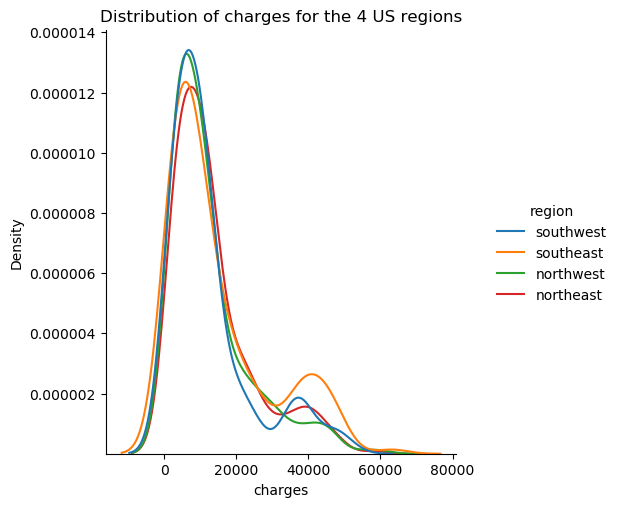

In [14]:
sns.displot(df, x='charges', hue='region', kind='kde')
plt.title('Distribution of charges for the 4 US regions');

As shown in the plot above, there is very minimal difference in the medical charges for the 4 US regions.

# 4. Further Pre-processing

Before we use our data for modeling, we have to transformed categorical columns. Many machine learning algorithms cannot work with categorical data directly. For our case, we convert the categorical feature into one-hot representation. 

## 4.1 Handling Categorical Data

We will use one-hot encoding for features `sex`, `smoker`, `region`. We can use pandas.get_dummies() method.

In [15]:
df_dummy = pd.get_dummies(df[['sex', 'smoker', 'region']],drop_first = True )

In [16]:
df_ = df.drop(['sex', 'smoker', 'region'], axis=1)
df_cleaned = pd.merge(df_, df_dummy, left_index=True, right_index=True)
df_cleaned.head(2)

age   bmi  num_children  charges  sex_male  smoker_yes  region_northwest  \
0   19  27.9             0 16,884.9         0           1                 0   
1   18 33.77             1 1,725.55         1           0                 0   

   region_southeast  region_southwest  
0                 0                 1  
1                 1                 0

## 4.2 Scaling

I choose not to scale numerical features such as `age`, `bmi`, `num_children` and `charges` since all features are in the same scale.

# 5. Results and Discussion


The first part of this section will focus on choosing the best estimator for our dataset. The second part will be the implementation of Partial dependence and Individual conditional expectation plots.

## 5.1 Modeling

Before we demonstrate PD and ICE plots, we will choose a model that will give us the highest accuracy in predicting medical charges. The 7 regressors used in the study are K-Nearest neigbor, Linear Regression, LASSO, Ridge, Decision trees, Random Forest, and Gradient Boosting models. At first, we split our data into three sets for training, validating and testing our models. We will use GridSearchCV from sklearn to exhaustively search over specified parameter values for the regressors.

To evaluate performance, we will measure the accuracy score metric. The model with highest test accuracy will be chosen.

### 7-in-1 Auto ML using GridSearchCV

In [17]:
def plot_feature_importance(abs_coefs, feature_names, target_name):
    
    coefs_count = len(abs_coefs)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.barh(np.arange(coefs_count), sorted(abs_coefs))

    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(feature_names[np.argsort(abs_coefs)])
    ax.set_title('List of Important Features with weights for target='
                 +target_name)
    
    
def pipeline_modeling(X_train, y_train, X_val, y_val, X_test, y_test,
             model, parameters=None, target_name='cnt'):
    
    scores = {'model_name': str(model)[:-2],
             'opt_hyperparameter': None,
             'val_score': None,
             'train_score': None,
             'test_score': None,
             'run_time':None}
    
    shuffle_split = ShuffleSplit(n_splits=5, test_size=.20)
    grid_obj = GridSearchCV(model,
                            parameters, n_jobs=-1, 
                            cv=shuffle_split,
                            return_train_score=True)
    
    
    start_time = time.time()
    grid_obj = grid_obj.fit(X_val, y_val)
    results_df = pd.DataFrame(grid_obj.cv_results_)
    results_df = (
        results_df
        .set_index(results_df["params"].apply(
            lambda x: "_".join(str(val) for val in x.values()))
        ))
    best_model = grid_obj.best_estimator_

    # fit best model on train data
    best_model.fit(X_train, y_train)

    # get accuracy scores
    scores['val_score'] = round(grid_obj.best_score_, 4)
    scores['train_score'] = round(best_model.score(X_train, y_train),4)
    scores['test_score'] = round(best_model.score(X_test, y_test),4)
    run_time = (time.time() - start_time)
    scores['run_time'] = run_time
    
    model = str(model)[:-2]
    feature_names = X_train.columns
    if model in ['RandomForestRegressor', 'DecisionTreeRegressor',
                     'GradientBoostingRegressor']:
        
        coefs = best_model.feature_importances_
        top_predictor = feature_names[np.argmax(np.abs(coefs))]
        plot_feature_importance(np.abs(coefs), feature_names, target_name)
        
    elif model in ['LinearRegression', 'Ridge', 'Lasso']:
        coefs = best_model.coef_
        plot_feature_importance(np.abs(coefs), feature_names, target_name)
        top_predictor = feature_names[np.argmax(np.abs(coefs))]

    else: #if knn
        top_predictor = None
        
    scores['opt_hyperparameter'] = str(best_model)
    scores['top_predictor'] = top_predictor
    scores['target'] = target_name
    
    return scores, results_df


### Split the dataset

In [18]:
features = ['age', 'bmi', 'num_children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest']

X = df_cleaned[features]
y = df_cleaned['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                            test_size=0.15, random_state=1)
X_train.shape, X_val.shape, X_test.shape

((909, 8), (161, 8), (268, 8))

#### 1. Random Forest

In [19]:
parameters = {'max_depth': [2, 3, 4], # 5, 6,],
              'n_estimators': [50, 75, 100, 200]
             } 
model = RandomForestRegressor(random_state=0)
scores_dict, cv_rf = pipeline_modeling(X_train, y_train, X_val, y_val,
                                       X_test, y_test,
                                    model, parameters, target_name = y.name)
df_rf = pd.DataFrame(scores_dict, index=[0])
df_rf

model_name  \
0  RandomForestRegressor(random_state=   

                                  opt_hyperparameter  val_score  train_score  \
0  RandomForestRegressor(max_depth=3, n_estimator...     0.8152       0.8685   

   test_score  run_time top_predictor   target  
0      0.8696   7.12901          None  charges

#### 2. Decision Trees

model_name                  opt_hyperparameter  val_score  \
0  DecisionTreeRegressor  DecisionTreeRegressor(max_depth=3)     0.8046   

   train_score  test_score  run_time top_predictor   target  
0       0.8613      0.8598  0.256588    smoker_yes  charges

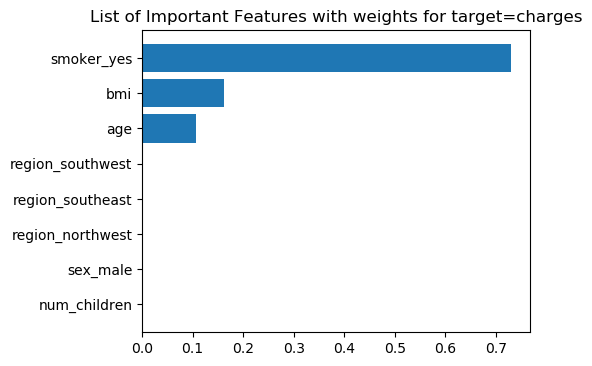

In [20]:
parameters = {'max_depth':[2, 3, 4, 5,6,7,8,9,10]}
model = DecisionTreeRegressor()
scores_dict, cv_dt = pipeline_modeling(X_train, y_train, X_val, y_val,
                                       X_test, y_test,
                                    model, parameters, target_name = y.name )
df_dt = pd.DataFrame(scores_dict, index=[0])
df_dt

#### 3. Gradient Boosting

model_name                      opt_hyperparameter  \
0  GradientBoostingRegressor  GradientBoostingRegressor(max_depth=2)   

   val_score  train_score  test_score  run_time top_predictor   target  
0     0.7279       0.8875      0.8752    1.9086    smoker_yes  charges

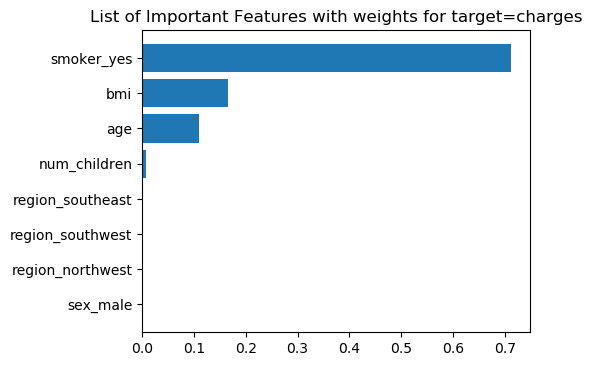

In [21]:
parameters = {'max_depth': [2, 3, 4, 5],
              'n_estimators': [50, 75, 100, 150],
              }

model = GradientBoostingRegressor()

scores_dict, cv_gb = pipeline_modeling(X_train, y_train, X_val, y_val, X_test,
                                       y_test, model, parameters,
                                       target_name=y.name)
   
df_gb = pd.DataFrame(scores_dict, index=[0])
df_gb

#### 4. Linear Regression

model_name                opt_hyperparameter  val_score  train_score  \
0  LinearRegression  LinearRegression(normalize=True)      0.584        0.757   

   test_score  run_time top_predictor   target  
0      0.7628  0.292128    smoker_yes  charges

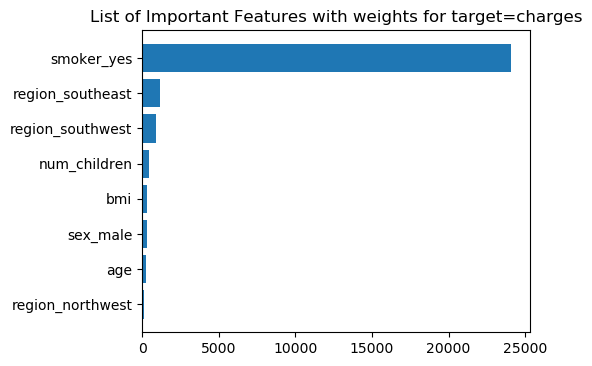

In [22]:
model = LinearRegression()
parameters = {'fit_intercept':[True], 'normalize':[True,False]}
scores_dict, cv_lr = pipeline_modeling(X_train, y_train, X_val, y_val, 
                                    X_test, y_test, model, parameters,
                                    target_name=y.name)

df_lr = pd.DataFrame(scores_dict, index=[0])
df_lr

#### 5. Lasso

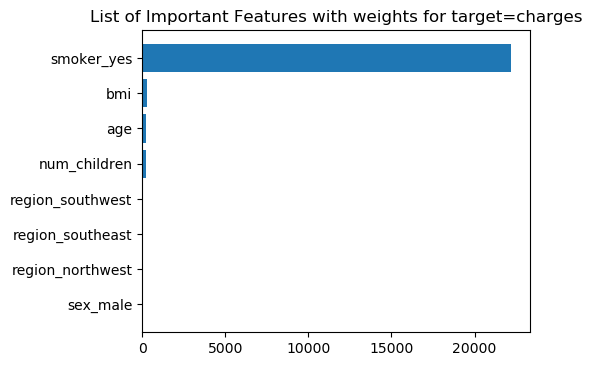

In [23]:
parameters = {'alpha' : [ 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3,
                5, 10, 15,  20, 100, 300, 1000]
             }
model = Lasso()

scores_dict, cv_lasso = pipeline_modeling(X_train, y_train, X_val, y_val,
                                          X_test, y_test,
                                 model, parameters, target_name=y.name)
df_lasso = pd.DataFrame(scores_dict, index=[0])

#### 6. Ridge

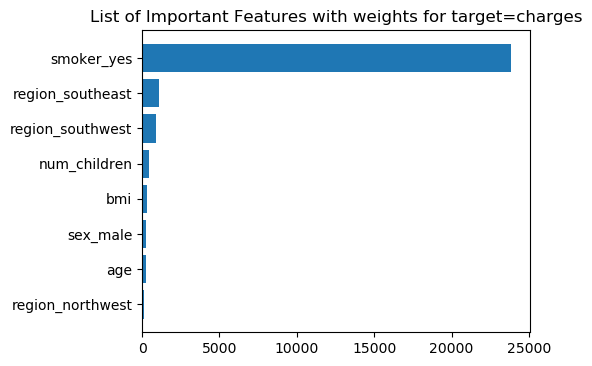

In [24]:
parameters = {'alpha' : [ 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3,
             5, 10, 15,  20, 100, 300, 1000]
             }
model = Ridge()
scores_dict, cv_rdg = pipeline_modeling(X_train, y_train, X_val, y_val,
                                        X_test, y_test,
                     model, parameters, target_name=y.name)

df_ridge = pd.DataFrame(scores_dict, index=[0])

#### 7. KNN

In [25]:
parameters = {'n_neighbors': np.arange(1,100) }
model = KNeighborsRegressor()

scores_dict, cv_knn = pipeline_modeling(X_train, y_train, X_val, y_val,
                                        X_test, y_test, model, parameters,
                                        target_name=y.name)
df_knn = pd.DataFrame(scores_dict, index=[0])
df_knn

model_name                   opt_hyperparameter  val_score  \
0  KNeighborsRegressor  KNeighborsRegressor(n_neighbors=53)     0.0892   

   train_score  test_score  run_time top_predictor   target  
0        0.142      0.1357    2.4509          None  charges

In [26]:
# concatenate all 7 models
df_models = pd.concat([df_knn, df_lr, df_ridge, df_lasso, df_dt, df_rf,
                       df_gb]).reset_index(drop=True)
df_models = df_models.sort_values(by='test_score', ascending=False
                                 ).reset_index(drop=True)
df_models

model_name  \
0            GradientBoostingRegressor   
1  RandomForestRegressor(random_state=   
2                DecisionTreeRegressor   
3                     LinearRegression   
4                                Ridge   
5                                Lasso   
6                  KNeighborsRegressor   

                                  opt_hyperparameter  val_score  train_score  \
0             GradientBoostingRegressor(max_depth=2)     0.7279       0.8875   
1  RandomForestRegressor(max_depth=3, n_estimator...     0.8152       0.8685   
2                 DecisionTreeRegressor(max_depth=3)     0.8046       0.8613   
3                   LinearRegression(normalize=True)      0.584        0.757   
4                                   Ridge(alpha=1.5)     0.5658       0.7569   
5                                   Lasso(alpha=300)     0.5945       0.7512   
6                KNeighborsRegressor(n_neighbors=53)     0.0892        0.142   

   test_score  run_time top_predictor   target  
0      0.8752    1.9086    smoker_yes  charges  
1      0.8696   7.12901          None  charges  
2      0.8598  0.256588    smoker_yes  charges  
3      0.7628  0.292128    smoker_yes  charges  
4      0.7627  0.416296    smoker_yes  charges  
5      0.7556  0.437128    smoker_yes  charges  
6      0.1357    2.4509          None  charges

**Insights**

Gradient Boosting is the best model for this case with test accuracy of ~88%. It is followed by Random Forest and Decision Trees. The best predictor for gradient boosting is the feature `smoker_yes` which is a flag if the individual smokes. 

Gradient Boosting and Random forest performed best because they can handle the complexity of the data. However, they lack interpretability. The general recommendation for both models is to use as many trees as possible. In most cases, with hundreds of trees, we wouldn't be able to understand why did they collectively made the decision that they made. Although we can also calculate the feature importance for the two models, we should be careful since the naive implementations for this are biased. When predictor variables are highly correlated, significance measures are known to be biased, resulting in suboptimal predictor variables being artificially preferred [[4](https://link.springer.com/content/pdf/10.1186%2F1471-2105-8-25.pdf)].

The important features of our best model is shown above in cell 21. Important feautures include `smoker_yes`, `bmi`, `age`, `num_children`. The contributions of the individual's location (region) and gender are close or equal to zero. When we find an acceptable feature set that reliably predicts our response variable, we may often end. However, it is occasionally beneficial to get a more in-depth grasp of how our models and systems work. To accomplish so, we'll need a different technique for determining the connection between the features and the response variable. In such case, we would need to use the general interpretability tools like ICE and PD plots which we will demonstate in the next section.

## 5.2 PD and ICE implementation

In [27]:
from sklearn.inspection import plot_partial_dependence

**Assumption: No correlated features**

Why should they be independent? PDP/ICE techniques are based on perturbation of data points. Dependent features when perturbed can result in a joint distribution that will have extrapolated data points that are infeasible in the real world. Explaining the marginal contribution of a feature in such a case can lead to spurious interpretations [[5](https://towardsdatascience.com/pitfalls-to-avoid-while-interpreting-machine-learning-pdp-ice-case-c63eeb596590)]. 

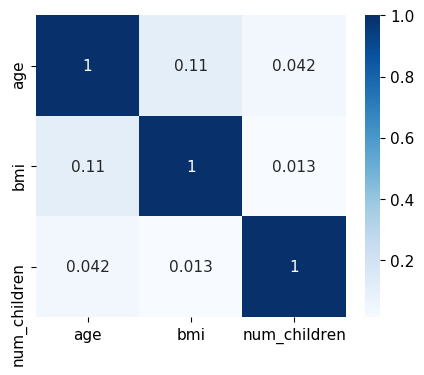

In [28]:
plt.figure(figsize=(5,4))
plt.rcParams.update({'font.size': 11})
sns.heatmap(df.drop('charges', axis=1).corr(), annot = True, cmap="Blues")
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

There are only 3 numerical features. For `age`, `bmi` and `num_children`, all seems are not correlated with each other. Since our samples do not violate the assumption needed for PD and ICE plots, we can guarantee that our PD and ICE are reliable. We can now start our implementation.

In [29]:
# best model 
df_models.iloc[0]['opt_hyperparameter']

'GradientBoostingRegressor(max_depth=2)'

In [30]:
# Training the model again using best hyperparamater
gbm = GradientBoostingRegressor(max_depth=2)

features = ['age', 'bmi', 'num_children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest']

X = df_cleaned[features]
y = df_cleaned['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state=1)
gbm = gbm.fit(X_train, y_train)
gbm.score(X_test, y_test)

0.8781657863717436

In [ ]:


# Checking the residuals of our samples
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(gbm, qqplot=False) #Instantiate a Residual Plot Class
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

**Partial Dependence**

The partial dependence plots of the target `charges` on `age`, `bmi`, `num_children`, `smoker_yes` are shown below.

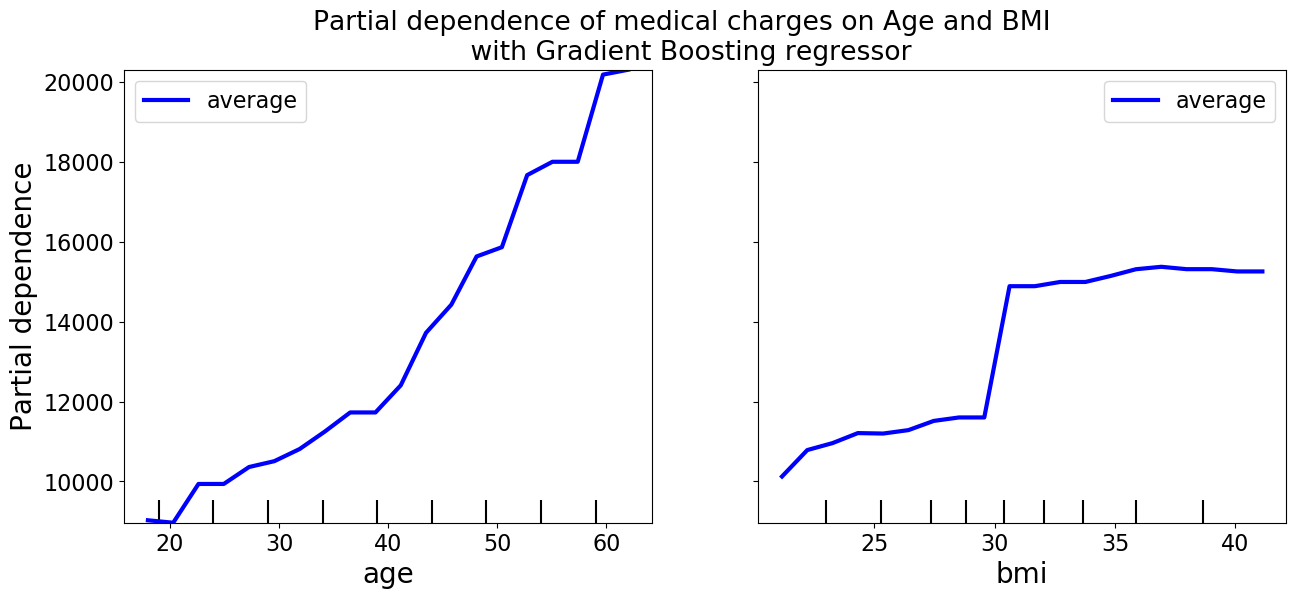

In [31]:
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.labelsize'] = 20

# default for kind= 'average' which is partial dependence (average effect)

features = ['age', 'bmi']
pdp_disp1 = plot_partial_dependence(
       gbm, X, features, subsample=1338,
       n_jobs=-1, grid_resolution=20, random_state=0, kind='average', method='brute',
       line_kw={"color": "blue", 'lw':3, 'label':'average'})
pdp_disp1.figure_.suptitle(
    'Partial dependence of medical charges on Age and BMI \n'
    ' with Gradient Boosting regressor')
pdp_disp1.figure_.subplots_adjust(hspace=0.2)

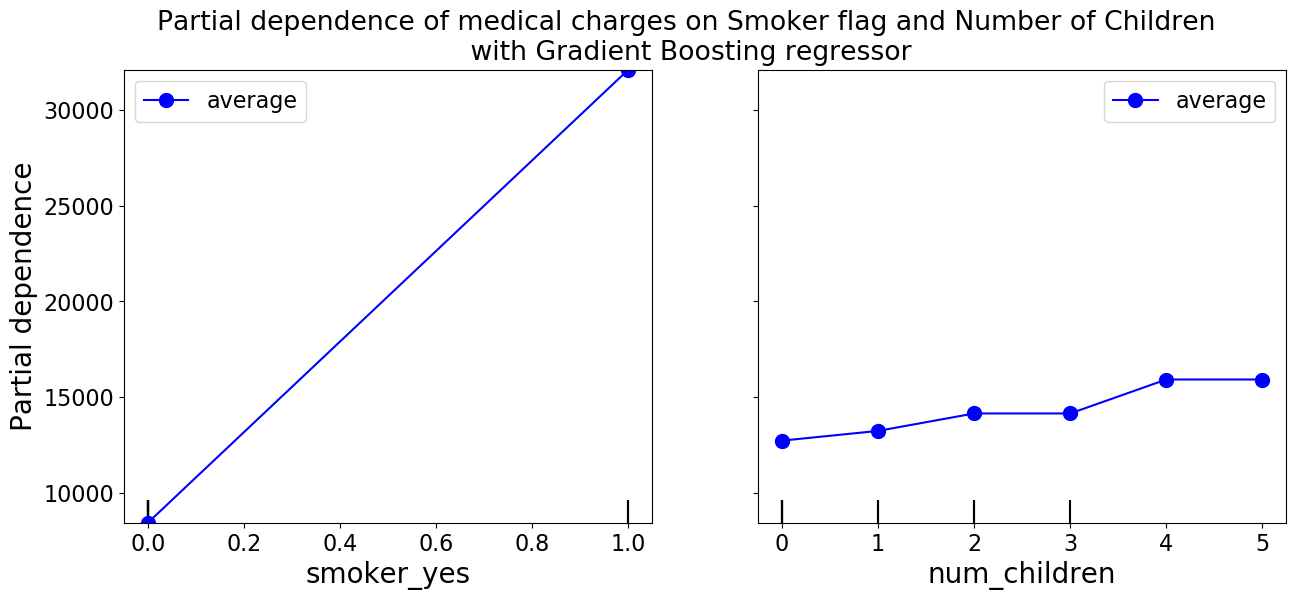

In [32]:
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.labelsize'] = 20


# default for kind= 'average' which is partial dependence (average effect)

features = ['smoker_yes','num_children']
pdp_disp2 = plot_partial_dependence(
       gbm, X, features, subsample=1338,
       n_jobs=-1, grid_resolution=20, random_state=0, kind='average', method='brute',
       line_kw={"color": "blue", 'label':'average', 'marker': 'o', 'markersize': 10})
pdp_disp2.figure_.suptitle(
    'Partial dependence of medical charges on Smoker flag and Number of Children\n'
    ' with Gradient Boosting regressor',
)
pdp_disp2.figure_.subplots_adjust(hspace=0.2)



**How do we get partial dependence?**
After training the model, we then use the model to predict medical charges given a feature.
We first predict the medical charge for that individual when age is 20. We then predict the medical charges if age is set 21. Then predict again for age equals to 22 and so on. We trace out how predicted `charges` changes (on the vertical axis) as we move from small values of age to large values (on the horizontal axis). We repeat this process with multiple individuals, and we plot the average predicted charges on the vertical axis. In using the package `plot_partial_dependence`, we set parameter `kind` to 'average' if we want to plot the partial dependence.

**Note:** In some cases, we can see negative values on the y-axis. This doesn't mean that the predicted value would be negative. Instead it means that the response variable would have been less than the actual average value for that feature.


For target feature `age`, we see that the older an individual is, the higher will be his/her predicted medical charge. We can also observe a linear relationship between predicted charges and age. For target feature `bmi`, the charges are low until BMI goes beyond 30. This explanation seems pretty intuitive. The charges are higher when the indvidual is obese. BMI that is within 25.0 to <30 falls within the overweight range. If BMI is 30.0 or higher, it falls within the obesity range. Obesity significantly increases the risk of chronic diseases such as cardiovascular disease, musculoskeletal disorders, type- 2 diabetes, coronary heart disease, osteo-arthritis and certain cancers [[6](http://www.who.int/mediacentre/factsheets/fs311/en/)].



For target feature `num_children`, the more children covered by the medical insurance, there is a slight increase on the medical charge. Its effect is relatively small as compared to age and BMI. For smokers, we see an obvious difference. Being a smoker increases the medical charges of an individual.  Smoking has been known to be linked to cancer, heart disease, stroke and other diseases [[7](http://www.who.int/mediacentre/factsheets/fs339/en/)].



Again, the y-axis of a partial dependence plot for regression represents the **marginal impact** of the independent variable to the dependent variable. E.g. if the line is at 0, then for that value of the independent variable, there is 0 impact to the dependent variable. It is basically a graph of effects.





**Individual Conditional Expectations**

The ICE plots of the target `charges` on `age`, `bmi`, `num_children`, `smoker_yes` are shown below.
In using the package `plot_partial_dependence`, we set parameter `kind` to 'individual' if we want to plot the Individual Conditional Expectations.

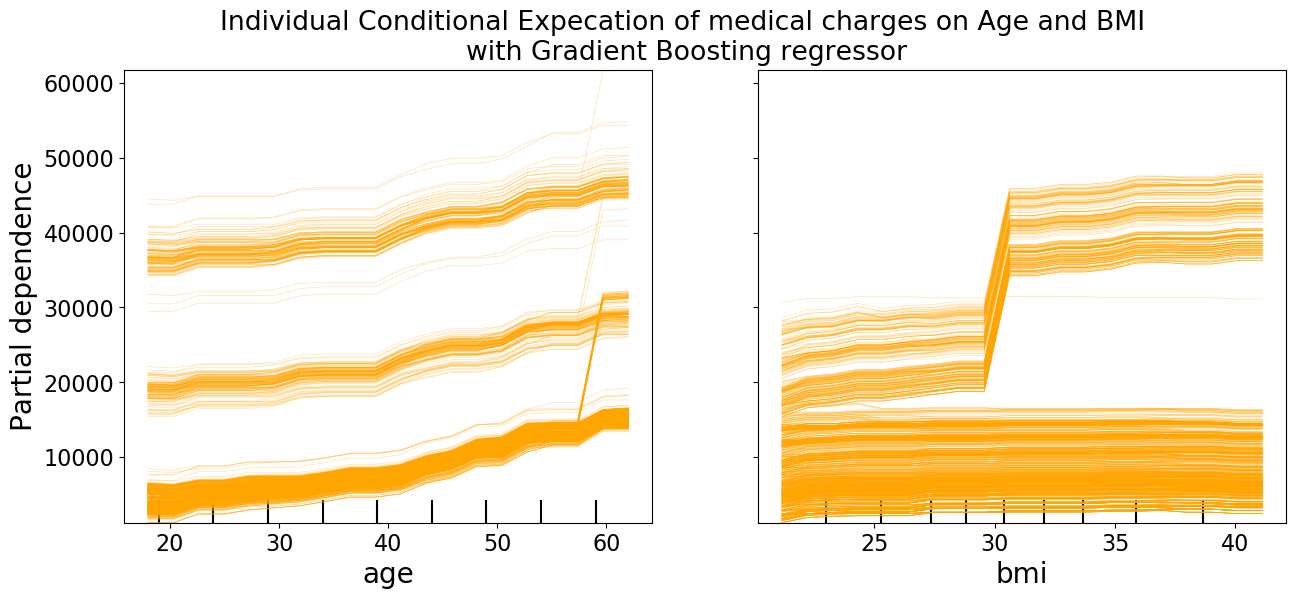

In [33]:
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.labelsize'] = 20

# if kind= 'individual' then ICE
# Plotting ICE requires using the slower method='brute' option.

features = ['age', 'bmi']
ice_disp1 = plot_partial_dependence(
       gbm, X, features, subsample=1338, kind='individual', method='brute',
       n_jobs=-1, grid_resolution=20, random_state=0,
       line_kw={"color": "orange", 'alpha':0.2,  'label':'ICE'})

ice_disp1.figure_.suptitle(
   'Individual Conditional Expecation of medical charges on Age and BMI \n'
    'with Gradient Boosting regressor'
)
ice_disp1.figure_.subplots_adjust(hspace=0.2)

Similarly, an individual conditional expectation (ICE) plot shows the dependence between the target function and a feature of interest. However, unlike partial dependence plots, which show the average effect of the features of interest, ICE plots visualize the dependence of the prediction on a feature for each sample separately, with one line per sample. Only one feature of interest is supported for ICE plots.

From the ICE plots, we observed the individual samples and its impact to medical charges. Let’s look at `bmi` and its impact to medical charges. We have samples where the effect of BMI to the prediction is flat even if BMI is high as shown above. Interestingly, we have also samples that peak when BMI reaches 30. 


If we further analyze it, we will know that these 2 patterns are for smokers and non-smokers. Let us plot the effect of BMI if individuals are smokers, as shown below.

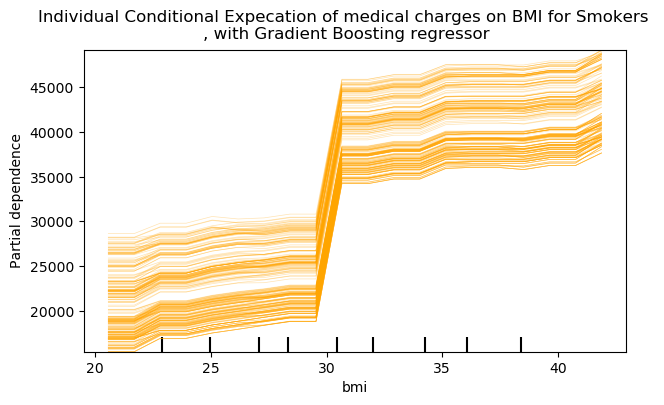

In [34]:
X_smoker = X[X['smoker_yes'] ==1]

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.labelsize'] = 10

# if kind= 'individual' then ICE
# Plotting ICE requires using the slower method='brute' option.

features = ['bmi']
ice_disp3 = plot_partial_dependence(
       gbm, X_smoker, features, subsample=1338, kind='individual', method='brute',
       n_jobs=-1, grid_resolution=20, random_state=0,
       line_kw={"color": "orange", 'alpha':0.2,  'label':'ICE'})

ice_disp3.figure_.suptitle(
   'Individual Conditional Expecation of medical charges on BMI for Smokers \n,'
  ' with Gradient Boosting regressor'
)
ice_disp3.figure_.subplots_adjust(hspace=0.3)


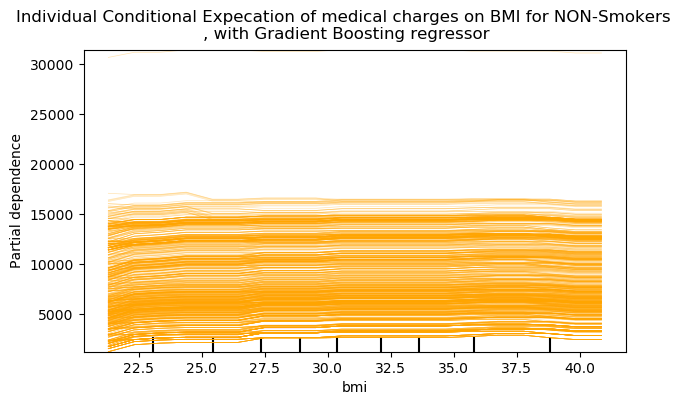

In [35]:
X_nonsmoker = X[X['smoker_yes'] ==0]

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.labelsize'] = 10

# if kind= 'individual' then ICE
# Plotting ICE requires using the slower method='brute' option.

features = ['bmi']
ice_disp4 = plot_partial_dependence(
       gbm, X_nonsmoker, features, subsample=1338, kind='individual', method='brute',
       n_jobs=-1, grid_resolution=20, random_state=0,
       line_kw={"color": "orange", 'alpha':0.2,  'label':'ICE'})

ice_disp4.figure_.suptitle(
   'Individual Conditional Expecation of medical charges on BMI for NON-Smokers \n,'
  ' with Gradient Boosting regressor'
)
ice_disp4.figure_.subplots_adjust(hspace=0.3)


Our guess is right! Our model gives lower predicted charges for people who does not smoke regardless of its BMI. For BMI < 30 and a smoker individual, the predicted charges is low. However, if the person smokes and BMI > 30, the model will predict its charges to be high.

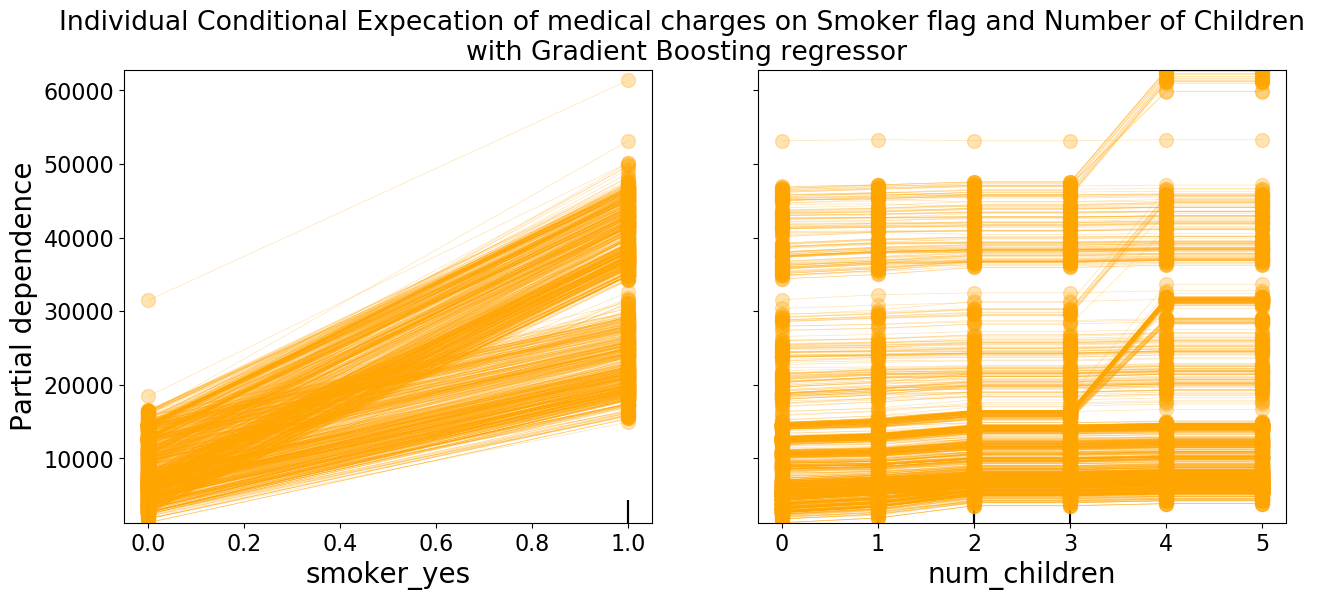

In [36]:
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.labelsize'] = 20


features = ['smoker_yes','num_children']
ice_disp2 = plot_partial_dependence(
       gbm, X, features, subsample=1338,
       n_jobs=-1, grid_resolution=20, random_state=0, kind='individual', method='brute',
       line_kw={"color": "orange",  'alpha':0.2, 'marker': 'o', 'markersize': 10})
ice_disp2.figure_.suptitle(
    'Individual Conditional Expecation of medical charges on Smoker flag and Number of Children \n'
    'with Gradient Boosting regressor'
)
ice_disp2.figure_.subplots_adjust(hspace=0.2)



We observed a similar pattern for ICE and PD plots for features `smoker_yes` and `num_children`.

**Combining PD and ICE plots**

Since PD can cancel positive and negative trends, combining PD and ICE can show the overall behavior of our ML model as shown in the plots. If we want to plot the ICE and PD together, we can set the `kind` parameter to 'both'. However, prettifying the plots is difficult since the package `plot_partial_dependence` has no parameters for setting different colors for the two plots.

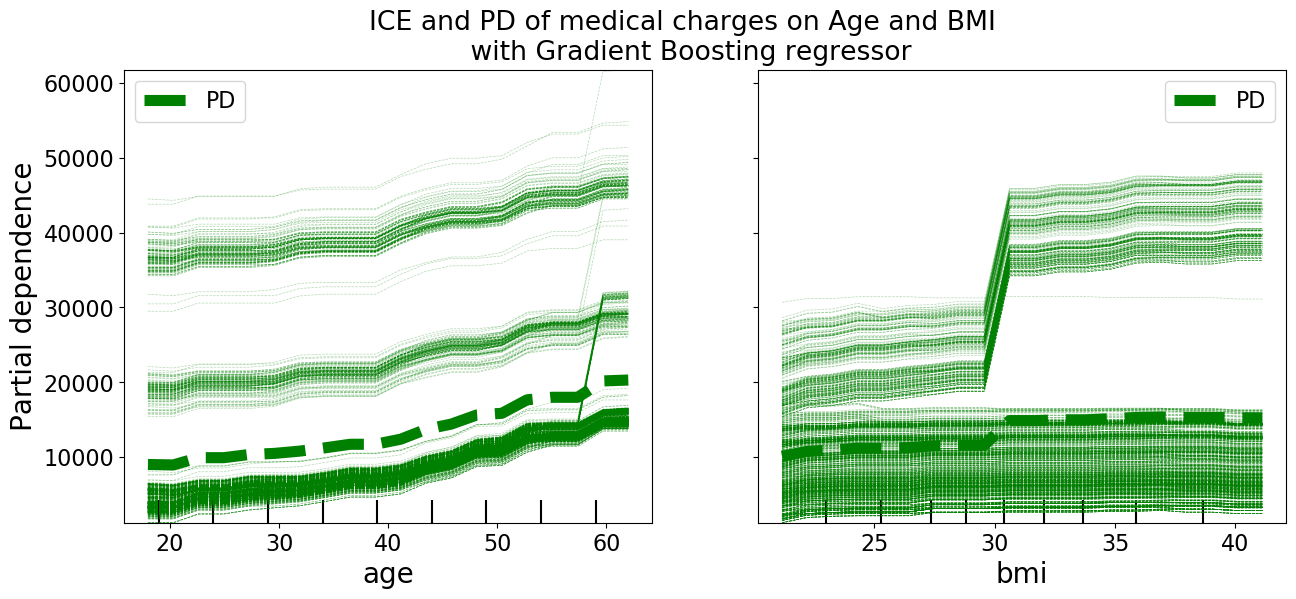

In [37]:
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.labelsize'] = 20

features = ['age', 'bmi']
ice_pdp = plot_partial_dependence(
       gbm, X, features, subsample=1338, kind='both', method='brute',
       n_jobs=-1, grid_resolution=20, random_state=0,
       line_kw={"color": "green", 'label':'PD', 'linestyle':'dashed', 'lw':8})

ice_pdp.figure_.suptitle(
   'ICE and PD of medical charges on Age and BMI'
    ' \n with Gradient Boosting regressor'
)
ice_pdp.figure_.subplots_adjust(hspace=0.3)

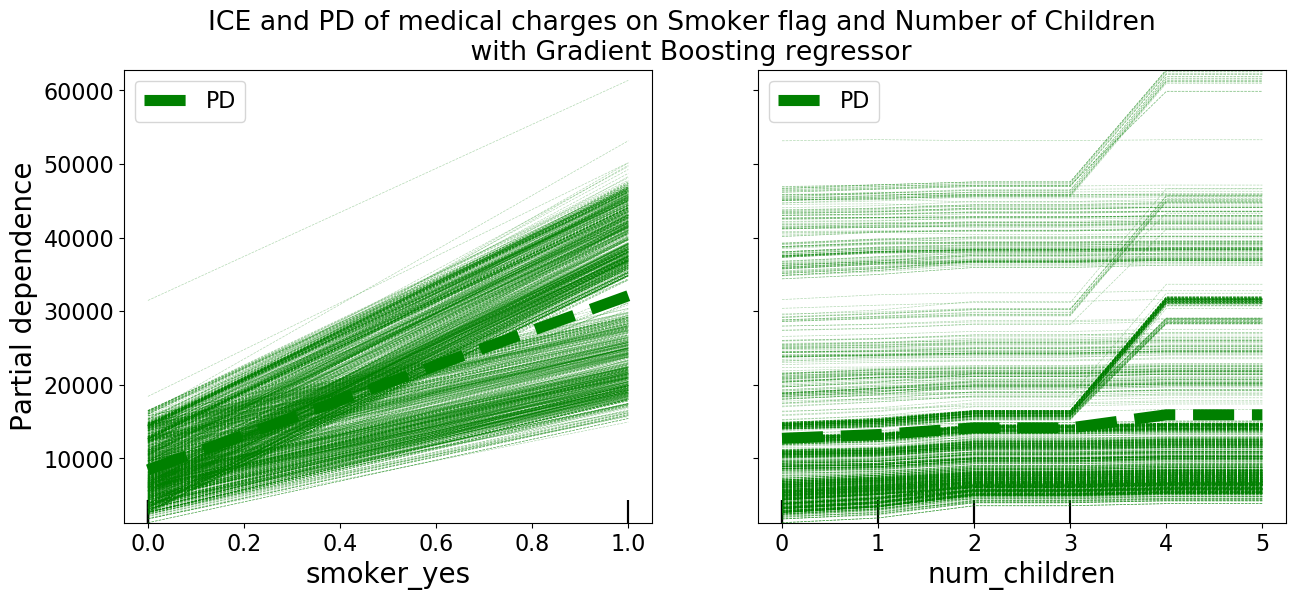

In [38]:
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.labelsize'] = 20

# if kind= 'individual' then ICE
# Plotting ICE requires using the slower method='brute' option.

features = ['smoker_yes','num_children']
ice_pdp = plot_partial_dependence(
       gbm, X, features, subsample=1338, kind='both', method='brute',
       n_jobs=-1, grid_resolution=20, random_state=0,
       line_kw={"color": "green", 'label':'PD', 'linestyle':'dashed', 'lw':8})

ice_pdp.figure_.suptitle(
   'ICE and PD of medical charges on Smoker flag and Number of Children'
    ' \n with Gradient Boosting regressor'
)
ice_pdp.figure_.subplots_adjust(hspace=0.3)

**Note** The dashed bold line represents PD plots.

We can prettify the plots manually as shown below.

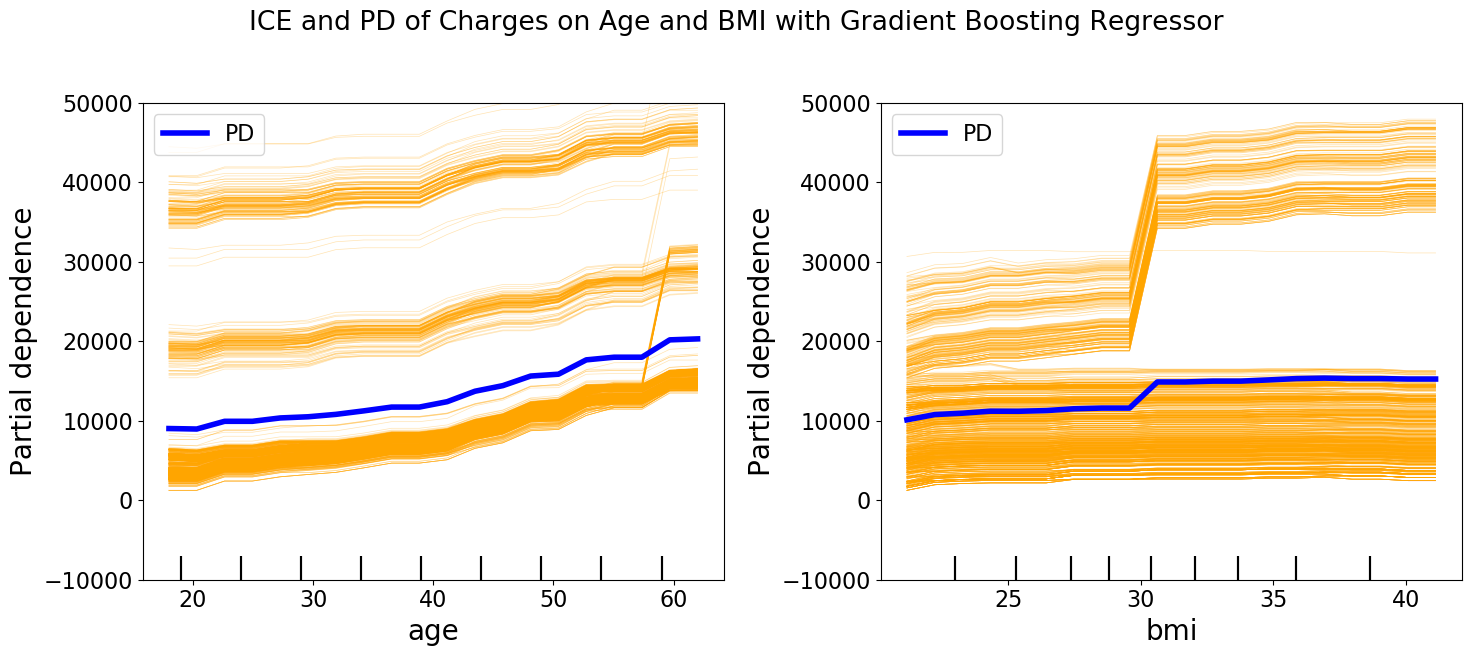

In [39]:
# To prettify our plots
plt.rcParams["legend.loc"] = 'upper left'
fig, ax = plt.subplots(1,2,figsize=(15,6))
ice_disp1.plot(ax=ax, line_kw={"color": "orange", 'alpha':0.2,
                                    'label': 'ICE'})
pdp_disp1.plot(ax=ax, line_kw={"color": "blue", 'lw':4,
                                      'label':'PD'});

custom_ylim = (-10_000, 50_000)
plt.setp(ax,ylim=custom_ylim)
plt.suptitle('ICE and PD of Charges on Age and BMI with Gradient '
             'Boosting Regressor', y=1.1)
plt.tight_layout();

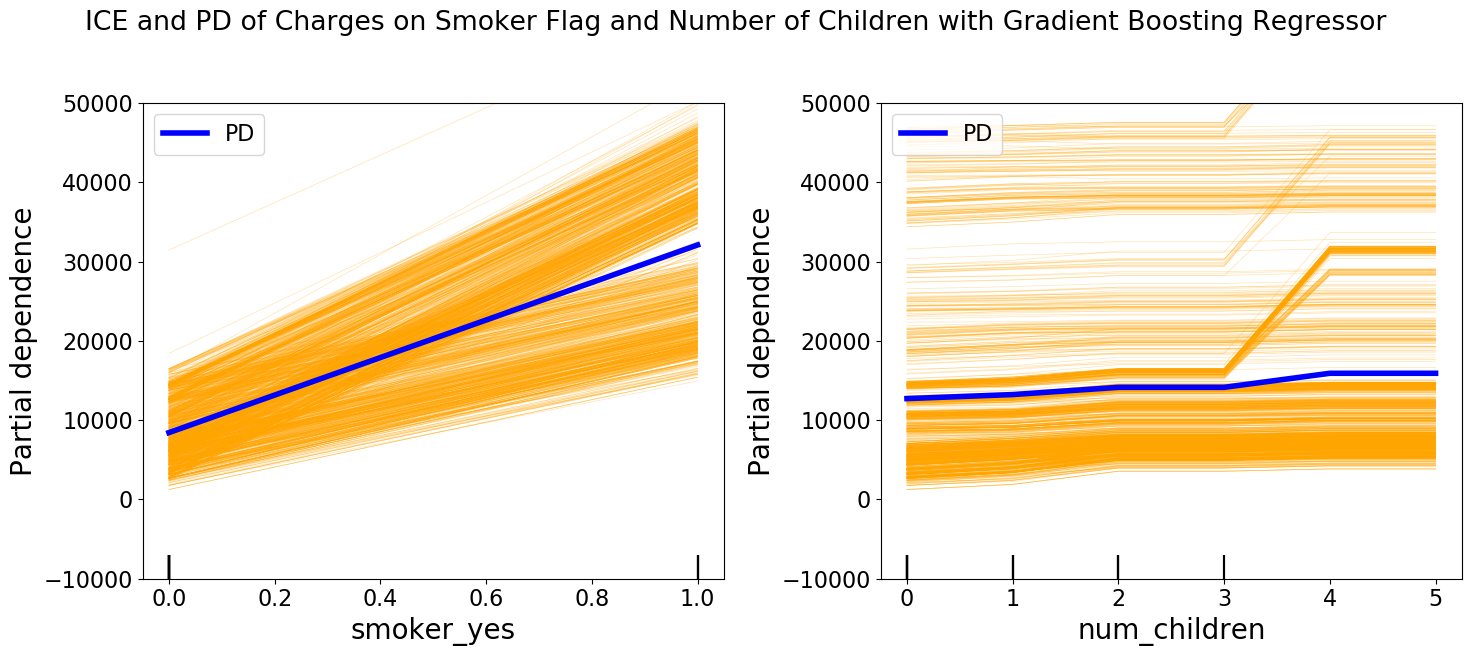

In [40]:
# To prettify our plots
plt.rcParams["legend.loc"] = 'upper left'
fig, ax = plt.subplots(1,2,figsize=(15,6))
ice_disp2.plot(ax=ax, line_kw={"color": "orange", 'alpha':0.2,
                                    'label': 'ICE'})
pdp_disp2.plot(ax=ax, line_kw={"color": "blue", 'lw':4,
                                      'label':'PD'});

plt.suptitle('ICE and PD of Charges on Smoker Flag and Number of Children'
             ' with Gradient Boosting Regressor', y=1.1)
custom_ylim = (-10_000, 50_000)
plt.setp(ax,ylim=custom_ylim)
plt.tight_layout();


# 6. Conclusion

We've shown that it is possible to interpret the behavior of complex ML models using PD and ICE plots. They are useful in conveying the results of our blackbox model to non-technical people. Partial dependence, the isolated effect of a specific variable or variables on the response variable, is important to researchers and practitioners in many disparate fields such as medicine, business, and the social sciences. For our example, insurance company can make better informed decisions if they want to predict the medical charges of their customers. If we use a blackbox model, we will still have a better understanding of how our models predict medical charges given an individual's demographics or clinical features using PD and ICE plots. Insurance companies might need to know how smoking or BMI affects the medical charges.

# 7. References

[1] Dassen,T., Hou, N., Kronseder, V. (2020). Introduction to Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE). Retrieved 13 September 2021, https://compstat-lmu.github.io/iml_methods_limitations/introduction.html

[2] Dassen,T., Hou, N., Kronseder, V. (2020). Introduction to Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE). Retrieved 13 September 2021, from https://compstat-lmu.github.io/iml_methods_limitations/pdp.html

[3] Molnar, C. (2021). Interpretable Machine Learning. Retrieved 13 September 2021, from https://christophm.github.io/interpretable-ml-book/ice.html

[4] Strobl, C., Boulesteix, A., Zeileis, A., & Hothorn, T. (2007). Bias in random forest variable importance measures: Illustrations, sources and a solution. BMC Bioinformatics, 8(1). doi: 10.1186/1471-2105-8-25
(https://link.springer.com/content/pdf/10.1186%2F1471-2105-8-25.pdf)

[5] Pitfalls To Avoid while Interpreting Machine Learning-PDP/ICE case.(2021).Retrieved 13 September 2021, from https://towardsdatascience.com/pitfalls-to-avoid-while-interpreting-machine-learning-pdp-ice-case-c63eeb596590

[6] WHO.(http://www.who.int/mediacentre/factsheets/fs311/en/)

[7] WHO.(http://www.who.int/mediacentre/factsheets/fs339/en/)
